In [250]:
# pip install project_tests

# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)


In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns
from sklearn.metrics import f1_score
sns.set()
%matplotlib inline

df = pd.read_csv("../Recommendations-with-IBM/data/user-item-interactions.csv")
df_content = pd.read_csv("../Recommendations-with-IBM/data/articles_community.csv")
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [252]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


## <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

#### Articles interactions per user

In [253]:
# dataframe with number of articles interactions per user
user_article = df.groupby('email')['article_id'].count()
user_article

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc6cfa435937ca0df967b44e9178439d04e3537     2
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    32
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81    10
fffb93a166547448a0ff0232558118d59395fecd    13
Name: article_id, Length: 5148, dtype: int64

<Figure size 720x360 with 0 Axes>

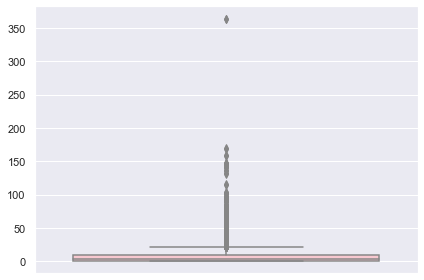

In [254]:
# let's build a boxplot
plt.figure(figsize=(10,5))

plt.subplots()
sns.set_style('whitegrid')

sns.boxplot(user_article.values,color='pink',orient='v')
plt.tight_layout()

In [255]:
user_article.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

Text(0.5, 0, 'Number of User-Article Interactions')

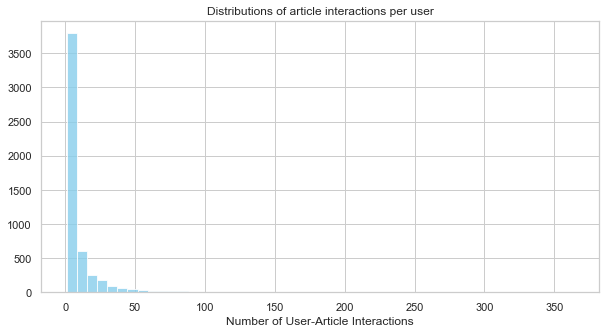

In [256]:
# plot graph
plt.figure(figsize=(10,5))
plt.hist(user_article, bins=50, alpha=0.8, color='skyblue')
plt.title('Distributions of article interactions per user') 
plt.xlabel('Number of User-Article Interactions')

In [257]:
# Fill in the median and maximum number of user_article interactios below
# 50% of individuals interact with ____ number of articles or fewer.
median_val = df.groupby('email')['article_id'].count().median() 


In [258]:
# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = df.groupby('email')['article_id'].count().max() 

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [259]:
df_content.shape

(1056, 5)

In [260]:
df_content.describe()

,article_id
count,1056.000000
mean,523.913826
std,303.480641
min,0.000000
25%,260.750000
50%,523.500000
75%,786.250000
max,1050.000000


In [261]:
# Find and explore duplicate articles
df_content.article_id.duplicated().sum()

5

In [262]:
# explore duplicate articles
duplicates = np.where(df_content.duplicated(['article_id']) == True)

for i in duplicates[0]:
    print(i, df_content[df_content['article_id'] == i]['doc_full_name'].values)

365 ["Go Serverless with Apex and Compose's MongoDB"]
692 ['15 Page Tutorial for R']
761 ['Variational auto-encoder for "Frey faces" using keras']
970 ['Launching RESTHeart into Production']
971 ['Defensive coding in Map/Index functions']


In [263]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates('article_id')

In [264]:
df_content.shape

(1051, 5)

#### DataFrame

In [265]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [266]:
unique_articles = df.article_id.nunique()
print('The number of unique articles that have at least one interaction is {}'.format(unique_articles))
total_articles = df_content.article_id.count()
print('The number of unique articles on the IBM platform is {}'.format(total_articles))
unique_users = df.email.nunique()
print('The number of unique users is {}'.format(unique_users))
user_article_interactions = df.shape[0]
print('The number of user-article interactions is {}'.format(user_article_interactions))

The number of unique articles that have at least one interaction is 714
The number of unique articles on the IBM platform is 1051
The number of unique users is 5148
The number of user-article interactions is 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [267]:
df.article_id.value_counts().head(2)

1429.0    937
1330.0    927
Name: article_id, dtype: int64

In [268]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df.article_id.value_counts().index[0])
most_viewed_article_id

'1429.0'

In [269]:
# The most viewed article in the dataset was viewed how many times?
max_views = df.article_id.value_counts().iloc[0] 
max_views

937

In [270]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [271]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


## <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [272]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['title'].value_counts().index.tolist()[:n]
    top_articles = [str(i) for i in top_articles]
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['article_id'].value_counts().index.tolist()[:n]
    top_articles = [str(i) for i in top_articles]
 
    return top_articles # Return the top article ids

In [273]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [274]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [275]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
#     user_item = df.groupby('user_id')['article_id'].value_counts().unstack().fillna(0)
#     user_item[user_item > 1] = 1
    
    df_count = df.groupby(['user_id', 'article_id']).count().reset_index() # create a new df based on count
    user_item = df_count.pivot_table(values='title', index='user_id', columns='article_id') # pivot so users on rows and article on columns
    user_item.replace(np.nan, 0, inplace=True) # replace nulls with 0s
    user_item=user_item.applymap(lambda x: 1 if x > 0 else x) # entries should be a 1 or 0


    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [276]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [277]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [278]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [279]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
   # compute similarity of each user to the provided user
    dot_prod_users = user_item.dot(np.transpose(user_item))
    
    # sort by similarity
    sim_users = dot_prod_users[user_id].sort_values(ascending = False)
    
    # create list of just the ids
    most_similar_users = sim_users.index.tolist()
    
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [280]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


In [281]:
user_id = 46
sims = user_item.loc[user_id, :].dot(user_item.T)
sims = sims.sort_values(ascending=False)
sims.head()

user_id
46      40.0
4201    40.0
3782    26.0
23      26.0
203     18.0
Name: 46, dtype: float64

In [282]:
user_similarity = list(sims.index.values)
user_similarity.remove(user_id) 
user_similarity[:3]

[4201, 3782, 23]

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [283]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []

    for idx in article_ids:
        article_names.append(df[df['article_id']==float(idx)].max()['title'])
    
    return article_names # Return the article names associated with list of article ids


In [284]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype('str')
    
    article_names = []

    for idx in article_ids:
        article_names.append(df[df['article_id']==float(idx)].max()['title']) # need to use df instead of df_content as it only has 1051 rows
    
    
    return article_ids, article_names # return the ids and names




In [285]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    
    user_articles_seen = get_user_articles(user_id)[0] #seen by our user
    closest_users = find_similar_users(user_id) # users closest to our user
    
    for others in closest_users:
        
        others_articles_seen = get_user_articles(others)[0] # articles seen by others like our user
        new_recs = np.setdiff1d(others_articles_seen, user_articles_seen, assume_unique=True) #find those not seen by user
        recs = np.unique(np.concatenate([new_recs, recs], axis = 0)) # concate arrays and only return unique values

        if len(recs) > m-1:
            break
            
    recs = recs[:m]
    recs.tolist()
    
    return recs # return your recommendations for this user_id    

In [286]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [287]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."

In [288]:
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [289]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # create neighbors dataframe with empty columns
    neighbors_df = pd.DataFrame(columns=['neighbor_id', 'similarity'])
    
    # set neighbor_id column equal to user_item index starting from 1
    neighbors_df['neighbor_id'] = user_item.index-1
    
    # make similarity column equal to most similar using dot product 
    dot_prod = user_item.dot(np.transpose(user_item))
    neighbors_df['similarity'] = dot_prod[user_id]
    
    # create new df based on number of interactions of users
    interacts_df = df.user_id.value_counts().rename_axis('neighbor_id').reset_index(name='num_interactions')
    
    # merge dataframes which creates number of interactions column from interacts_df
    neighbors_df = pd.merge(neighbors_df, interacts_df, on='neighbor_id', how='outer')
    
    # sort values on similarity and then number of interactions 
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending = False)
    
    # reset index
    neighbors_df = neighbors_df.reset_index(drop=True)
    
    # drop row with the user_id as itself will be most similar
    neighbors_df = neighbors_df[neighbors_df.neighbor_id != user_id]
    
    return neighbors_df # Return the dataframe specified in the doc_string

In [290]:
sims = user_item.loc[user_id, :].dot(user_item.T)

# order by similarity
sims = pd.DataFrame(sims.sort_values(ascending=False))
sims = sims.reset_index()
sims.columns = ['user_id', 'similarity']
sims = sims[sims.user_id != user_id]
sims.head()


,user_id,similarity
1,4201,40.0
2,3782,26.0
3,23,26.0
4,203,18.0
5,4459,18.0


In [291]:
get_top_sorted_users(26).head()

,neighbor_id,similarity,num_interactions
1,4453,13.0,25.0
2,23,9.0,364.0
3,3782,9.0,363.0
4,49,9.0,147.0
5,3697,9.0,145.0


In [292]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    
    user_articles_ids_seen, user_articles_names_seen = get_user_articles(user_id, user_item) #article ids seen by our user
    closest_neighs = get_top_sorted_users(user_id, df, user_item).neighbor_id.tolist() # neighbour user ids closest to our user
    
    for neighs in closest_neighs:
        
        neigh_articles_ids_seen, neigh_articles_names_seen = get_user_articles(neighs, user_item) # articles seen by others like our user
        new_recs = np.setdiff1d(neigh_articles_ids_seen, user_articles_ids_seen, assume_unique=True) #find those not seen by user
        recs = np.unique(np.concatenate([new_recs, recs], axis = 0)) # concate arrays and only return unique values

        if len(recs) > m-1:
            break
            
    recs = recs[:m]
    recs = recs.tolist() # convert to a list
    
    rec_names = get_article_names(recs, df=df)
    
    return recs, rec_names


In [293]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0', '1085.0', '109.0', '1150.0', '1151.0', '1152.0', '1153.0', '1154.0', '1157.0', '1160.0']

The top 10 recommendations for user 20 are the following article names:
['using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: chicago listings', 'tensorflow quick tips', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice reviews', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [294]:
### Tests with a dictionary of results
# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id
user1_most_sim

3933.0

In [295]:
# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id
user131_10th_sim

242.0

In [296]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

If we were given a new user, the functions required to make recommendations for the user would include the 'get_top_articles' or 'get_top_articles_ids' because we don't yet know what the user's preferences are. By using these particular functions we would be recommending the articles by popularity i.e. the articles which have the most interaction. 
Afterwards one could use collaborative filtering- and content- based recommendations. 



`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [297]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to. 
# Your recommendations here
new_user_recs = get_top_article_ids(10, df)

In [298]:
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [299]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


## <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [300]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [301]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [302]:
# Perform SVD on the User-Item Matrix Here
# use the built in to get the three matrices
u, s, vt = np.linalg.svd(user_item_matrix) 

In [303]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

We are able to use SVD here becauuse the use-item matrix has no missing values (NaN). This differs from the lesson which contained missing values and therefore FunkSVD was used instead. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

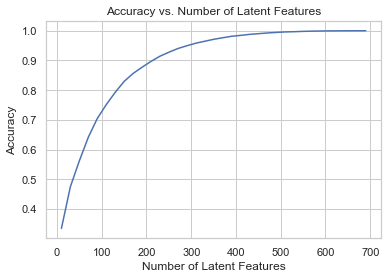

In [304]:
latent_features = np.arange(10,700+10,20)
sum_errs = []

for k in latent_features:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # apply dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # calculate error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(latent_features, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [305]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [306]:
user_item_test.describe()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
count,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,...,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000
mean,0.002933,0.013196,0.001466,0.017595,0.001466,0.021994,0.020528,0.014663,0.019062,0.014663,...,0.036657,0.017595,0.008798,0.014663,0.065982,0.017595,0.004399,0.004399,0.001466,0.004399
std,0.054113,0.114199,0.038292,0.131572,0.038292,0.146772,0.141901,0.120287,0.136842,0.120287,...,0.188056,0.131572,0.093451,0.120287,0.248434,0.131572,0.066226,0.066226,0.038292,0.066226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [307]:
test_idx

Int64Index([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801,
            ...
            5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
           dtype='int64', name='user_id', length=682)

In [308]:
print('user_item_train.shape : {}'.format(user_item_train.shape))
print('user_item_test.shape : {}'.format(user_item_test.shape))
print('users in test also in train : {}'.format(len(np.intersect1d(user_item_test.index, user_item_train.index))))
print('users in test not in train : {}'.format(len(set(user_item_test.index) - set(user_item_train.index))))
print('movies in test also in train : {}'.format(len(np.intersect1d(user_item_test.columns, user_item_train.columns))))
print('movies in test not in train : {}'.format(len(set(user_item_test.columns) - set(user_item_train.columns))))

user_item_train.shape : (4487, 714)
user_item_test.shape : (682, 574)
users in test also in train : 20
users in test not in train : 662
movies in test also in train : 574
movies in test not in train : 0


In [309]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 



sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [310]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [311]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
s_train.shape, u_train.shape, vt_train.shape

((714,), (4487, 4487), (714, 714))

In [312]:
# users in test set that can be predicted for training set
u_test = u_train[user_item_train.index.isin(test_idx), :]
u_test.shape[0]

20

In [313]:
# movies in test set that can be predicted for training set
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]
vt_test.shape[1]

574

In [314]:
user_item_test_new = user_item_test.loc[user_item_train.index.intersection(test_idx), user_item_train.columns.intersection(test_arts)]

In [315]:
user_item_test_new.shape

(20, 574)

In [316]:
# calculating the balance of the new test dataset
test_have_score = user_item_test_new[user_item_test_new != 0].count().sum()
test_have_no_score = user_item_test_new[user_item_test_new == 0].count().sum()

perc_test_have_score = round((test_have_score/(test_have_score+test_have_no_score))*100,3)
perc_test_have_no_score = round((test_have_no_score/(test_have_score+test_have_no_score))*100,3)

print('In the new test DataSet :')
print('{} relations user/movie have a score or {} % of the new test set'.format(test_have_score,perc_test_have_score))
print('{} relations user/movie have no score or {} % of the new test set'.format(test_have_no_score,perc_test_have_no_score))

In the new test DataSet :
218 relations user/movie have a score or 1.899 % of the new test set
11262 relations user/movie have no score or 98.101 % of the new test set


In [317]:
num_latent_feats = np.arange(10,700+10,20)

sum_errs_train = []
sum_errs_test = []

sum_f1_train_score = []
sum_f1_test_score = []

for k in num_latent_feats:
    
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test_new, user_item_test_est)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)
    
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)
    
    train_error = round((1 - np.array(sum_errs_train)/df_train.shape[0])[-1],3)
    test_error = round((1 - np.array(sum_errs_test)/df_test.shape[0])[-1],3)
    
    f1_train_score = round(f1_score(np.array(user_item_train).flatten(), np.array(user_item_train_est).flatten(),average='weighted',labels=[1.0]),3)
    f1_test_score = round(f1_score(np.array(user_item_test_new).flatten(), np.array(user_item_test_est).flatten(),average='weighted',labels=[1.0]),3)
    
    sum_f1_train_score.append(f1_train_score)
    sum_f1_test_score.append(f1_test_score)

## <a class="anchor" id="Matrix-Fact">Part V: Conclusion</a>

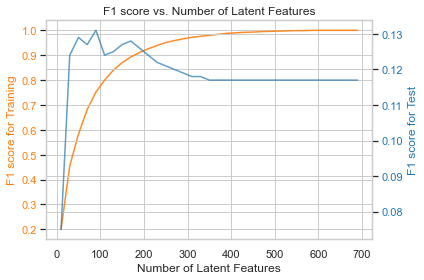

In [318]:
# plot of training and test accuracies
fig, ax1 = plt.subplots()

color = 'tab:orange'
ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('F1 score for Training', color=color)
ax1.plot(num_latent_feats,sum_f1_train_score,label = 'Training F1',alpha=0.9, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('F1 score vs. Number of Latent Features')

ax2 = ax1.twinx()  # second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('F1 score for Test', color=color)
ax2.plot(num_latent_feats,sum_f1_test_score,label = 'Testing F1',alpha=0.7, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

F1 takes into account both precision and recall: a balance of the two is what F1 scores on. The F1 score for the test and training models increase with increasing latent features but at a different rate. The two accuracies intersect at around 200 latent features. As the number of latent features surpass 200, the F1 score of the test model decreases (indicative of over-fitting with the number of latent features used): the F1 score of the training set increases before levelling off. 

In [319]:
test_real_vs_est = pd.DataFrame(np.array(user_item_test_new).flatten().tolist())
test_real_vs_est['est'] = pd.DataFrame(np.array(user_item_test_est).flatten().tolist())

In [320]:
sse = 0
num_rated = 0
preds, acts = [], []
actual_v_pred = np.zeros((2,2))
for idx in range(len(test_real_vs_est[0])):
    try:
        sse += (test_real_vs_est[0][idx] - test_real_vs_est['est'][idx])**2
        num_rated+=1
        preds.append(test_real_vs_est['est'][idx])
        acts.append(test_real_vs_est[0][idx])
        actual_v_pred[int(test_real_vs_est[0][idx]), int(round(test_real_vs_est['est'][idx]))]+=1
        
    except:
        continue
    
rmse = np.sqrt(sse/num_rated)
perc_rated = num_rated/len(test_real_vs_est[0])

Text(0.5, 1.0, 'Actual vs. Predicted Values')

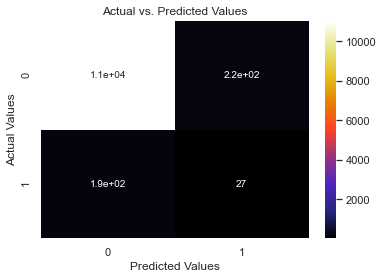

In [321]:
import seaborn as sns
sns.heatmap(actual_v_pred,annot=True,cmap="CMRmap")
plt.xlabel("Predicted Values");
plt.ylabel("Actual Values");
plt.title("Actual vs. Predicted Values")

Text(0.5, 1.0, 'Accuracy vs. Number of Latent Features')

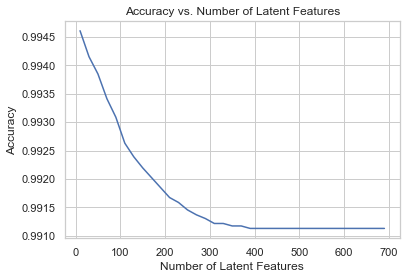

In [322]:
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df.shape[0])
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')

plt.title('Accuracy vs. Number of Latent Features')

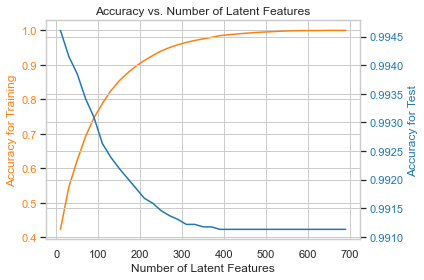

In [323]:
# plot of training and test accuracies
fig, ax1 = plt.subplots()

color = 'tab:orange'
ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('Accuracy for Training', color=color)
ax1.plot(num_latent_feats, 1 - np.array(sum_errs_train)/df.shape[0], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Accuracy vs. Number of Latent Features')

ax2 = ax1.twinx()  # second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy for Test', color=color)
ax2.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df.shape[0], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

In [324]:
train_acc = 1 - np.array(sum_errs_train)/(user_item_train.shape[0] * user_item_test.shape[1]);
test_acc = 1 - np.array(sum_errs_test)/(user_item_test.shape[0] * user_item_test.shape[1]);
print("Accuracy of the training data; min: {}; max: {}".format(min(train_acc), max(train_acc)))
print("Accuracy of the testing data; min: {}; max: {}".format(min(test_acc), max(test_acc)))

Accuracy of the training data; min: 0.9896945803168115; max: 1.0
Accuracy of the testing data; min: 0.9989577692174073; max: 0.9993664871713652


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

Conclusion:
Initially when plotting the testing and training accuracies on the same axis the plot was presented incorrectly; using twin axis and separating the accuracies resulted in the correct plot being produced. 

The training accuray model inceases exponentially in accuracy as the number of latent features increases; after approximately 300 latent features the accuracy reaches a maximum and becomes constant in its value. The testing accuracy model is the opposite and decreases exponentially with increasing latent features: this is most likley the result of overfitting the data with latent features. The train and test accuracies intersect at approximately 90 latent features; this would be a good number to set as any further increase would lead to a decrease in the test accuracy. 

In the top left of the plot, the test accuracy is > 99% for less than 20 users that the SVD can be used to make recommendations for. Having more data i.e., more users for both the test and training data would improve the results. 

Discussion:
- Use alternative methods e.g., content- and rank- based recommendations or a combination of recommendation methods; collaborative and knowledge-based. Currently, using the SVD is hindered by the cold start problem in that predictions can only be made for users and articles that are present in both test and training sets. New user can be given the rank based recommendation method and for those users who have interacted with articles, a collaborative filtering (user-user) and rank based recommendations can be implemented. 

- Use A/B testing to validate the model and assess against other recommendation methods. This would be applied for new users in relation to the cold start problem. We would use A/B testing on separate groups, exposing the groups to different recommendation algorithms and evaluate the outcome. 
 


In [325]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1

Resources:
    
- https://knowledge.udacity.com/questions/387214
- https://knowledge.udacity.com/questions/807332
- https://knowledge.udacity.com/questions/572066